# Model 1: predict listing price based on listing features

In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics

from xgboost import XGBRegressor
import category_encoders as ce
import datetime
import joblib

[Python - How to Save and Load ML Models](https://www.kaggle.com/prmohanty/python-how-to-save-and-load-ml-models)

## Finalize features and target variable
- target variable is price

In [225]:
df = pd.read_csv('../../Large_Data/Listings_combined_cleaned.csv')
df.head()

,neighborhood_recoded,county,property_type_recoded,accommodates,bedrooms,beds,bathrooms,bathroom_type,minimum_nights,maximum_nights,...,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f,price,availability_30,availability_60,availability_90
0,Western Addition,San Francisco,Entire serviced apartment,3,1.0,2.0,1.0,private,2,30,...,1,1,1,1,1,1,161.0,7,7,10
1,Bernal Heights,San Francisco,Entire rental unit,5,2.0,3.0,1.0,private,30,60,...,1,1,1,1,1,1,235.0,30,60,90
2,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,60,...,1,1,1,1,1,1,56.0,30,60,90
3,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,90,...,0,1,1,1,1,1,56.0,30,60,90
4,Western Addition,San Francisco,Entire condominium (condo),4,2.0,2.0,1.5,private,7,111,...,0,1,1,1,1,1,895.0,29,59,89


In [226]:
df.shape

(9825, 39)

In [227]:
df.columns

Index(['neighborhood_recoded', 'county', 'property_type_recoded',
       'accommodates', 'bedrooms', 'beds', 'bathrooms', 'bathroom_type',
       'minimum_nights', 'maximum_nights', 'Wifi', 'Dedicated_workspace',
       'Patio_or_balcony', 'Backyard', 'BBQ_grill', 'Outdoor_furniture',
       'Indoor_fireplace', 'Private_entrance', 'Pool', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'neighborhood_overview_f', 'host_about_f', 'host_response_time_f',
       'host_response_rate_f', 'host_acceptance_rate_f',
       'host_neighbourhood_f', 'price', 'availability_30', 'availability_60',
       'availability_90'],
      dtype='object')

In [228]:
# create
X = df.drop(columns=['price','availability_30', 'availability_60','availability_90'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7368, 35), (7368,), (2457, 35), (2457,))

In [229]:
# create train for EDA
train = df.loc[df.index.isin(X.index), :]
print(train.shape)
train.head()

(9825, 39)


,neighborhood_recoded,county,property_type_recoded,accommodates,bedrooms,beds,bathrooms,bathroom_type,minimum_nights,maximum_nights,...,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f,price,availability_30,availability_60,availability_90
0,Western Addition,San Francisco,Entire serviced apartment,3,1.0,2.0,1.0,private,2,30,...,1,1,1,1,1,1,161.0,7,7,10
1,Bernal Heights,San Francisco,Entire rental unit,5,2.0,3.0,1.0,private,30,60,...,1,1,1,1,1,1,235.0,30,60,90
2,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,60,...,1,1,1,1,1,1,56.0,30,60,90
3,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,90,...,0,1,1,1,1,1,56.0,30,60,90
4,Western Addition,San Francisco,Entire condominium (condo),4,2.0,2.0,1.5,private,7,111,...,0,1,1,1,1,1,895.0,29,59,89


In [230]:
X_train.head()

,neighborhood_recoded,county,property_type_recoded,accommodates,bedrooms,beds,bathrooms,bathroom_type,minimum_nights,maximum_nights,...,review_scores_value,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f
4852,Redwood City,San Mateo,Private room in residential home,4,2.0,2.0,1.0,shared,15,1125,...,4.81,63,0,0,1,0,1,1,1,1
4052,Noe Valley,San Francisco,Private room in residential home,2,1.0,1.0,1.5,shared,2,7,...,5.00,6,6,2,0,1,0,0,0,1
8104,San Jose,Santa Clara,Private room in residential home,2,1.0,1.0,3.0,shared,2,1125,...,4.87,67,18,1,1,1,1,1,1,1
1396,Bernal Heights,San Francisco,Private room in guest suite,2,1.0,1.0,1.0,private,2,14,...,4.90,141,11,3,0,0,0,0,0,1
7150,San Jose,Santa Clara,Private room in residential home,2,1.0,1.0,1.0,private,1,2,...,4.90,105,3,0,1,1,1,1,1,0


## EDA

In [105]:
train.describe()

,accommodates,bedrooms,beds,bathrooms,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,...,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f,price,availability_30,availability_60,availability_90
count,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,...,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000
mean,3.480305,1.593181,2.028702,1.416896,13.044784,569.837150,4.764960,4.814749,4.757261,4.880370,...,0.731501,0.707277,0.828601,0.828601,0.861272,0.875623,178.069313,11.231552,27.325293,46.218626
std,2.415604,0.975522,1.569959,0.826013,30.318371,514.153885,0.407623,0.379128,0.420152,0.327301,...,0.443201,0.455035,0.376877,0.376877,0.345680,0.330027,148.448029,11.269745,22.415682,32.691111
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,30.000000,4.710000,4.790000,4.690000,4.890000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,81.000000,0.000000,1.000000,13.000000
50%,2.000000,1.000000,1.000000,1.000000,3.000000,365.000000,4.880000,4.930000,4.890000,4.970000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,134.000000,8.000000,27.000000,51.000000
75%,4.000000,2.000000,3.000000,2.000000,30.000000,1125.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,219.000000,22.000000,49.000000,78.000000
max,16.000000,9.000000,27.000000,10.000000,1125.000000,1125.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1000.000000,30.000000,60.000000,90.000000


In [106]:
# Price

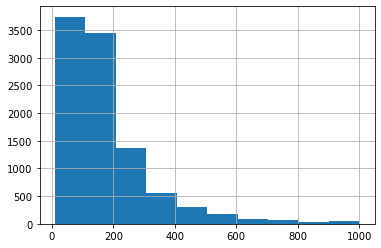

In [107]:
train['price'].hist();

Text(0.5, 1.1, 'Price per night by county')

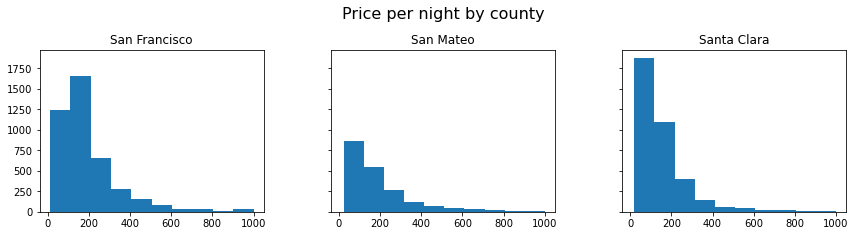

In [108]:
train.hist(column='price', by='county', figsize=(14,3), layout=(1,3), xrot=0, legend=False, sharex=True, sharey=True)
;
plt.suptitle('Price per night by county', x=0.5, y=1.1, fontsize=16)
#plt.savefig('../Plots/price_bycounty_hist2.png')

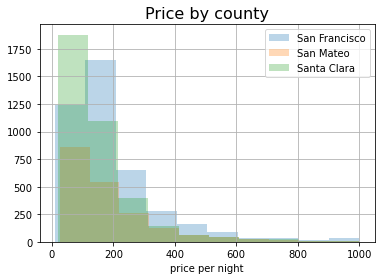

In [109]:
train.groupby('county')['price'].hist(alpha=0.3, legend=True)
plt.legend()
plt.title('Price by county', fontsize=16)
plt.xlabel('price per night');

#plt.savefig('../Plots/price_bycounty_hist.png')

''

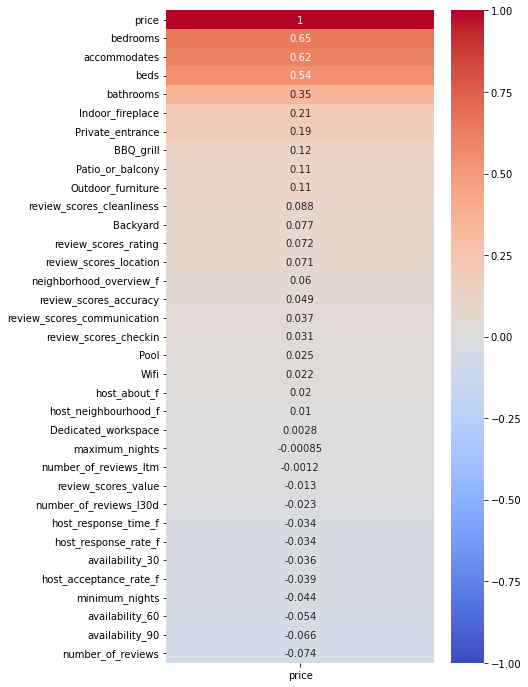

In [118]:
plt.figure(figsize=(6,12))
sns.heatmap(train.corr()[['price']].sort_values('price',ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
; 

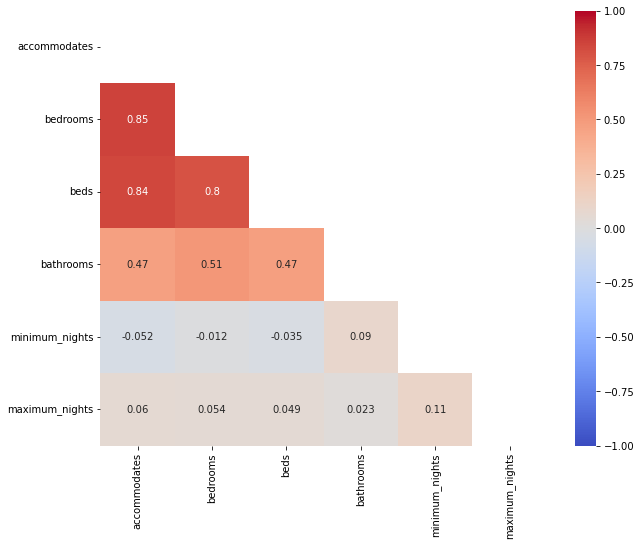

In [119]:
mask = np.zeros_like(train[['accommodates','bedrooms','beds','bathrooms','bathroom_type','minimum_nights','maximum_nights']].corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10,8))
sns.heatmap(train[['accommodates','bedrooms','beds','bathrooms','bathroom_type','minimum_nights','maximum_nights']].corr(), 
            mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1);

Text(0.5, 0.98, 'Listing price by size related features')

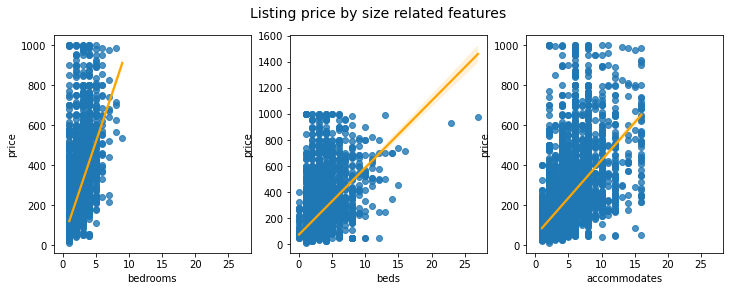

In [120]:
figure, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True)

ax1 = sns.regplot(x='bedrooms',     y='price', data=train, ax=axes[0], line_kws={'color':'orange'})
ax2 = sns.regplot(x='beds',         y='price', data=train, ax=axes[1], line_kws={'color':'orange'})
ax3 = sns.regplot(x='accommodates', y='price', data=train, ax=axes[2], line_kws={'color':'orange'})

plt.suptitle('Listing price by size related features', fontsize=14)

**Observations**: 
1. Listing price is correlated with the number of bedrooms and beds and the number of people it can accommodate. 
2. The number of beds, bedrooms and people the unit can accommodate are highly correlated.

In [123]:
# price by categorical 

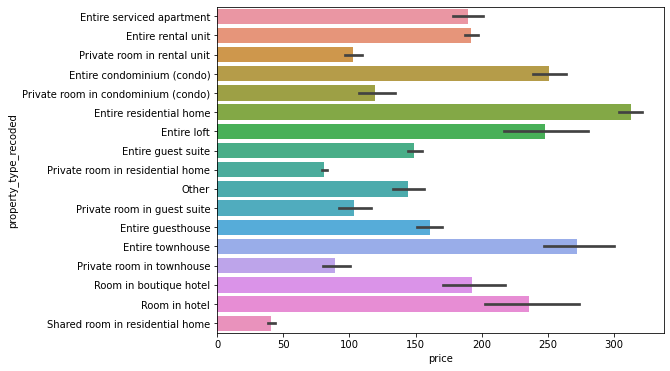

In [126]:
plt.figure(figsize=(8, 6))
sns.barplot(y='property_type_recoded', x='price', data=train, orient='h');

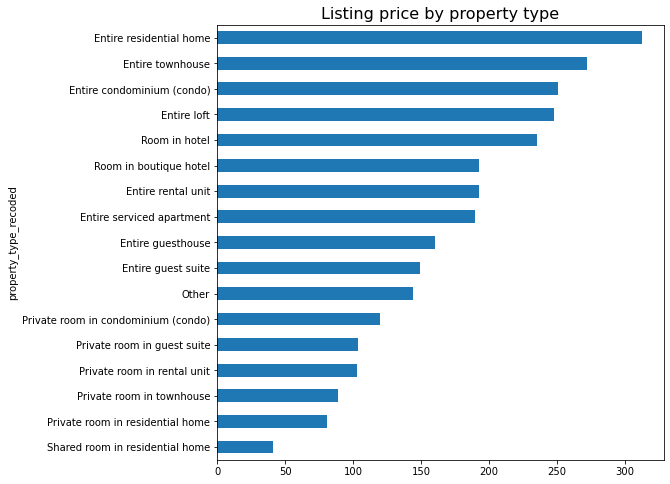

In [128]:
plt.figure(figsize=(8,8))
train.groupby('property_type_recoded').mean()['price'].sort_values(ascending=True).plot.barh()
plt.title('Listing price by property type', fontsize=16); 

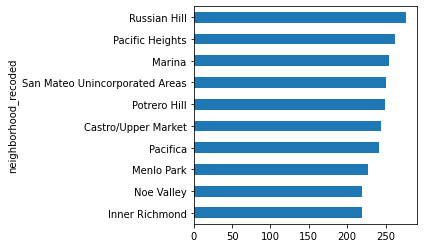

In [138]:
plt.figure(figsize=(4,4))
train.groupby('neighborhood_recoded').mean()['price'].sort_values(ascending=True).tail(10).plot.barh(); 

## Modeling

In [231]:
list(X_train['property_type_recoded'].unique())

['Private room in residential home',
 'Private room in guest suite',
 'Entire guest suite',
 'Room in boutique hotel',
 'Private room in condominium (condo)',
 'Entire residential home',
 'Entire rental unit',
 'Entire loft',
 'Entire guesthouse',
 'Entire serviced apartment',
 'Other',
 'Private room in rental unit',
 'Room in hotel',
 'Entire condominium (condo)',
 'Entire townhouse',
 'Private room in townhouse',
 'Shared room in residential home']

In [232]:
print(X_train.shape)
X_train.head()

(7368, 35)


,neighborhood_recoded,county,property_type_recoded,accommodates,bedrooms,beds,bathrooms,bathroom_type,minimum_nights,maximum_nights,...,review_scores_value,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f
4852,Redwood City,San Mateo,Private room in residential home,4,2.0,2.0,1.0,shared,15,1125,...,4.81,63,0,0,1,0,1,1,1,1
4052,Noe Valley,San Francisco,Private room in residential home,2,1.0,1.0,1.5,shared,2,7,...,5.00,6,6,2,0,1,0,0,0,1
8104,San Jose,Santa Clara,Private room in residential home,2,1.0,1.0,3.0,shared,2,1125,...,4.87,67,18,1,1,1,1,1,1,1
1396,Bernal Heights,San Francisco,Private room in guest suite,2,1.0,1.0,1.0,private,2,14,...,4.90,141,11,3,0,0,0,0,0,1
7150,San Jose,Santa Clara,Private room in residential home,2,1.0,1.0,1.0,private,1,2,...,4.90,105,3,0,1,1,1,1,1,0


In [233]:
# save m1_X_train
X_train.to_csv('../Data/m1_X_train.csv')

In [234]:
# get the data shape after one hot encoding 

# https://contrib.scikit-learn.org/category_encoders/onehot.html
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')

X_train_ohe = ohe.fit_transform(X_train, use_cat_names=True)
X_train_ohe.shape

(7368, 98)

In [235]:
#X_train_ohe.columns

### Baseline model

In [244]:
# train set
price_pred_base_train = y_train.mean()
print(f'Average listing price: {round(price_pred_base_train, 2)}')

price_base_mse = np.mean((y_train - price_pred_base_train)**2)
print(f'price_base_mse: {round(price_base_mse)}')
'''
price_pred_base_R2_train = metrics.r2_score(y_train, price_pred_base_train)
price_pred_base_mse_train = metrics.mean_squared_error(y_train, price_pred_base_train)
print(f'price_pred_base_R2_train: {round(price_pred_base_R2_train, 4)}')
print(f'price_pred_base_R2_train: {round(price_pred_base_R2_train, 4)}')

# test set
price_pred_base_test = y_test.mean()

price_pred_base_R2_test = metrics.r2_score(y_test, price_pred_base_test)
price_pred_base_mse_test = metrics.mean_squared_error(y_test, price_pred_base_test)
print(f'price_pred_base_R2_test: {round(price_pred_base_R2_test, 4)}')
print(f'price_pred_base_mse_test: {round(price_pred_base_mse_test, 4)}')
'''

Average listing price: 177.53
price_base_mse: 21698


"\nprice_pred_base_R2_train = metrics.r2_score(y_train, price_pred_base_train)\nprice_pred_base_mse_train = metrics.mean_squared_error(y_train, price_pred_base_train)\nprint(f'price_pred_base_R2_train: {round(price_pred_base_R2_train, 4)}')\nprint(f'price_pred_base_R2_train: {round(price_pred_base_R2_train, 4)}')\n\n# test set\nprice_pred_base_test = y_test.mean()\n\nprice_pred_base_R2_test = metrics.r2_score(y_test, price_pred_base_test)\nprice_pred_base_mse_test = metrics.mean_squared_error(y_test, price_pred_base_test)\nprint(f'price_pred_base_R2_test: {round(price_pred_base_R2_test, 4)}')\nprint(f'price_pred_base_mse_test: {round(price_pred_base_mse_test, 4)}')\n"

### Random Forest regressor

#### Default parameter values

In [143]:
m1_pipe_rf_base = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

m1_pipe_rf_base.fit(X_train, y_train)
m1_pipe_rf_base_pred_train = m1_pipe_rf_base.predict(X_train)
m1_pipe_rf_base_pred_test = m1_pipe_rf_base.predict(X_test)

m1_pipe_rf_base_R2_train = m1_pipe_rf_base.score(X_train, y_train)
m1_pipe_rf_base_R2_test = m1_pipe_rf_base.score(X_test, y_test)
print('m1_pipe_rf_base_R2_train: ', round(m1_pipe_rf_base_R2_train, 4))
print('m1_pipe_rf_base_R2_test: ', round(m1_pipe_rf_base_R2_test, 4))

m1_pipe_rf_base_mse_train = metrics.mean_squared_error(y_train, m1_pipe_rf_base_pred_train)
m1_pipe_rf_base_mse_test = metrics.mean_squared_error(y_test, m1_pipe_rf_base_pred_test)
print('m1_pipe_rf_base_mse_train', round(m1_pipe_rf_base_mse_train, 4))
print('m1_pipe_rf_base_mse_test', round(m1_pipe_rf_base_mse_test, 4))

m1_pipe_rf_base_R2_train:  0.9504
m1_pipe_rf_base_R2_test:  0.6592
m1_pipe_rf_base_mse_train 1076.3492
m1_pipe_rf_base_mse_test 7851.2171


#### GridSearchCV

In [153]:
m1_pipe_rf = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

m1_pipe_rf_params = {
    'rf__n_estimators': [400, 500, 600, 700, 800],
    'rf__max_depth': [6, 8, 10, 12, 14, 16, 18, 20],
    'rf__min_samples_split': [10, 20],
    'rf__min_samples_leaf': [5],
    #'rf__ccp_alpha': [0.0, 0.05, 0.1],
    'rf__max_features': [15, 30, 60, 90]
}
    
m1_gs_rf = GridSearchCV(m1_pipe_rf,
                        m1_pipe_rf_params,
                        cv=5)
        
print(datetime.datetime.now())

m1_gs_rf.fit(X_train, y_train)

print(datetime.datetime.now())
    

2022-02-03 17:10:19.385767
2022-02-03 18:23:56.538816


In [155]:
# predict
m1_gs_rf_pred_train = m1_gs_rf.predict(X_train)
m1_gs_rf_pred_test = m1_gs_rf.predict(X_test)

# evaluate
m1_gs_rf_R2_train = m1_gs_rf.score(X_train, y_train)
m1_gs_rf_R2_test = m1_gs_rf.score(X_test, y_test)
print('m1_gs_rf_R2_train: ', round(m1_gs_rf_R2_train, 4))
print('m1_gs_rf_R2_test:  ', round(m1_gs_rf_R2_test, 4))

m1_gs_rf_mse_train = metrics.mean_squared_error(y_train, m1_gs_rf_pred_train)
m1_gs_rf_mse_test = metrics.mean_squared_error(y_test, m1_gs_rf_pred_test)
print('m1_gs_rf_mse_train: ', round(m1_gs_rf_mse_train, 4))
print('m1_gs_rf_mse_test:  ', round(m1_gs_rf_mse_test, 4))

m1_gs_rf.best_estimator_

m1_gs_rf_R2_train:  0.8195
m1_gs_rf_R2_test:   0.6489
m1_gs_rf_mse_train:  3916.1887
m1_gs_rf_mse_test:   8090.0729


Pipeline(steps=[('ohe',
                 OneHotEncoder(cols=['neighborhood_recoded', 'county',
                                     'property_type_recoded', 'bathroom_type'],
                               use_cat_names=True)),
                ('rf',
                 RandomForestRegressor(max_depth=18, max_features=60,
                                       min_samples_leaf=5, min_samples_split=10,
                                       n_estimators=400, n_jobs=-1,
                                       random_state=42))])

In [159]:
m1_gs_rf_feature_importance = pd.DataFrame({'feature': m1_gs_rf.best_estimator_['ohe'].get_feature_names(),
                                         'importance': m1_gs_rf.best_estimator_['rf'].feature_importances_})

m1_gs_rf_feature_importance.to_csv('../Data/m1_gs_rf_feature_importance.csv', index=False)
m1_gs_rf_feature_importance.sort_values('importance', ascending=False).head(30)

,feature,importance
66,bedrooms,0.333338
65,accommodates,0.133263
68,bathrooms,0.064129
67,beds,0.043420
71,minimum_nights,0.036626
82,review_scores_rating,0.030064
88,review_scores_value,0.027649
87,review_scores_location,0.026085
72,maximum_nights,0.024939
70,bathroom_type_private,0.022662


In [160]:
# correlation between actual and predicted prices

import scipy
scipy.stats.pearsonr(y_test, m1_gs_rf_pred_test)

(0.8099105230959827, 0.0)

#### Save (and reload) gs_rf model with Joblib

In [161]:
import joblib

# save m1_gs_rf
m1_gs_rf_joblib_filename = '../Models/m1_gs_rf_joblib.pkl'

joblib.dump(m1_gs_rf, m1_gs_rf_joblib_filename)

# reload 
#m1_gs_rf_joblib = joblib.load(m1_gs_rf_joblib_filename)

# predict & evaluate
#m1_gs_rf_joblib_pred_test = m1_gs_rf_joblib.predict(X_test)
#m1_gs_rf_joblib.score(X_test, y_test)

['../Models/m1_gs_rf_joblib.pkl']

### XGBoost 

#### Default parameter values

In [258]:
m1_pipe_xgb_base = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(random_state=42))
])

m1_pipe_xgb_base.fit(X_train, y_train)

m1_pipe_xgb_base_pred_train = m1_pipe_xgb_base.predict(X_train)
m1_pipe_xgb_base_pred_test = m1_pipe_xgb_base.predict(X_test)


m1_pipe_xgb_base_R2_train = m1_pipe_xgb_base.score(X_train, y_train)
m1_pipe_xgb_base_R2_test = m1_pipe_xgb_base.score(X_test, y_test)
print('m1_pipe_xgb_base_R2_train: ', round(m1_pipe_xgb_base_R2_train, 4))
print('m1_pipe_xgb_base_R2_test: ', round(m1_pipe_xgb_base_R2_test, 4))

m1_pipe_xgb_base_mse_train = metrics.mean_squared_error(y_train, m1_pipe_xgb_base_pred_train)
m1_pipe_xgb_base_mse_test = metrics.mean_squared_error(y_test, m1_pipe_xgb_base_pred_test)
print('m1_pipe_xgb_base_mse_train: ', round(m1_pipe_xgb_base_mse_train, 4))
print('m1_pipe_xgb_base_mse_test: ', round(m1_pipe_xgb_base_mse_test, 4))

# save m1_gs_rf

# import joblib
m1_pipe_xgb_base_joblib_filename = '../Models/m1_pipe_xgb_base_joblib.pkl'

joblib.dump(m1_pipe_xgb_base, m1_pipe_xgb_base_joblib_filename)

m1_pipe_xgb_base_R2_train:  0.9406
m1_pipe_xgb_base_R2_test:  0.6595
m1_pipe_xgb_base_mse_train:  1288.0335
m1_pipe_xgb_base_mse_test:  7844.9063


['../Models/m1_pipe_xgb_base_joblib.pkl']

#### GridSearchCV - to run!!!

In [ ]:
m1_xgb = XGBRegressor(random_state=42)

m1_pipe_xgb = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(random_state=42))
])

m1_pipe_xgb_params = {
    'xgb__booster': ['gbtree','gblinear'],
    'xgb__n_estimators': [200,300,400],
    'xgb__eta': [0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4],
    'xgb__max_depth': [3,4,5,6,7,8]
}

m1_gs_xgb = GridSearchCV(m1_pipe_xgb,
                         m1_pipe_xgb_params, 
                         cv = 5)

print(datetime.datetime.now())

m1_gs_xgb.fit(X_train, y_train)

print(datetime.datetime.now())

In [ ]:
# predict
m1_gs_xgb_pred_train = m1_gs_xgb.predict(X_train)
m1_gs_xgb_pred_test = m1_gs_xgb.predict(X_test)

# evaluate
m1_gs_xgb_R2_train = m1_gs_xgb.score(X_train, y_train)
m1_gs_xgb_R2_test = m1_gs_xgb.score(X_test, y_test)
print(f'm1_gs_xgb_R2_train: {m1_gs_xgb_R2_train}')
print(f'm1_gs_xgb_R2_test: {m1_gs_xgb_R2_test}')

m1_gs_xgb_mse_train = metrics.mean_squared_error(y_train, m1_gs_xgb_pred_train)
m1_gs_xgb_mse_test = metrics.mean_squared_error(y_test, m1_gs_xgb_pred_test)
print(f'm1_gs_xgb_mse_train: {m1_gs_xgb_mse_train}')
print(f'm1_gs_xgb_mse_test: {m1_gs_xgb_mse_test}')

In [ ]:
m1_gs_xgb.best_estimator_

In [ ]:
m1_gs_xgb_feature_importance = pd.DataFrame({'feature': m1_gs_xgb.best_estimator_['ohe'].get_feature_names(),
                                         'importance': m1_gs_xgb.best_estimator_['xgb'].feature_importances_})

m1_gs_xgb_feature_importance.sort_values('importance', ascending=False).head(20)

#### Save and reload m1_gs_xgb with joblib

In [ ]:
# import joblib

# save m1_gs_rf
m1_gs_xgb_joblib_filename = '../Models/m1_gs_XGBoost_joblib.pkl'

joblib.dump(m1_gs_xgb, m1_gs_xgb_joblib_filename)

# reload 
m1_gs_xgb_joblib = joblib.load(m1_gs_xgb_joblib_filename)
# m1_gs_xgb_joblib

# predict & evaluate
m1_gs_xgb_joblib_pred_test = m1_gs_xgb_joblib.predict(X_test)
round(m1_gs_xgb_joblib.score(X_test, y_test), 4)

In [ ]:
X_train.columns

## Predict with mock input data

In [164]:
input_data = {'county': 'San Francisco',
              'neighborhood_recoded': 'Russian Hill', 
              'property_type_recoded': 'Entire residential home', 
              'accommodates': 6, 
              'bedrooms': 3, 
              'beds': 3,
              'bathrooms': 2.5, 
              'bathroom_type': 'private', 
              'minimum_nights': 1, 
              'maximum_nights': 3,
              'Wifi': 1, 
              'Dedicated_workspace': 0,
              'Private_entrance': 0, 
              'Patio_or_balcony': 1, 
              'Backyard': 1, 
              'BBQ_grill': 1, 
              'Outdoor_furniture': 1,
              'Indoor_fireplace': 0, 
              'Pool': 1, 
              'review_scores_rating': 4.8,
              'review_scores_accuracy': 4.8, 
              'review_scores_cleanliness': 4.8,
              'review_scores_checkin': 4.8,
              'review_scores_communication': 4.8,
              'review_scores_location': 4.8, 
              'review_scores_value': 4.8, 
              'number_of_reviews': 4.8,
              'number_of_reviews_ltm': 20, 
              'number_of_reviews_l30d': 5,
              'neighborhood_overview_f': 1, 
              'host_about_f': 1, 
              'host_response_time_f': 0,
              'host_response_rate_f': 0, 
              'host_acceptance_rate_f': 0,
              'host_neighbourhood_f': 0
}
input_data_df = pd.DataFrame(input_data, index=[0])

In [165]:
# load m1_gs_rf
m1_gs_rf_joblib_filename = '../Models/m1_gs_rf_joblib.pkl'

m1_gs_rf_joblib = joblib.load(m1_gs_rf_joblib_filename)
# m1_gs_rf_joblib

# predict & evaluate
m1_gs_rf_joblib_pred_input = m1_gs_rf_joblib.predict(input_data_df)[0]
print('Predicted basic price is', round(m1_gs_rf_joblib_pred_input, 2), 'dollars.')

Predicted basic price is 401.58 dollars.


# Stage 2 model: predict 30-day vacancy 
- with unit features, listing price and predicted price

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics

import category_encoders as ce
import datetime 
import pickle
import joblib

## Finalize features and label

In [179]:
df.shape

(9825, 39)

In [180]:
print(f'Number of rows with availability_30 as 0: {(df["availability_30"]==0).mean()}')
print(f'Number of rows if dropping availabilty_30 ==0: {(df["availability_30"]>0).sum()}')

Number of rows with availability_30 as 0: 0.3378117048346056
Number of rows if dropping availabilty_30 ==0: 6506


**Decision**: Becauase the tool is for hosts to adjust their listing price to reduce 30-day vacancy, those with no vacancy in 30 days will be dropped from the data. 

In [ ]:
df_m2 = df.loc[df['availability_30'] > 0,:]
df_m2.shape

In [ ]:
X = df_m2.drop(columns=['availability_30','availability_60','availability_90'])
y = df_m2['availability_30']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
train = df_m2.loc[df_m2.index.isin(X_train.index), :].sort_index()
print(train.shape)
train.head()  # include the 3 availability columns

# double check
# X_train.sort_index().index
# y_train.sort_index().index
# train.index

In [ ]:
# X_train.head()

In [ ]:
# get df shape after dummification
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train, use_cat_names=True)
X_train_ohe
X_train_ohe.shape

#### Create the price_basic column as the prediction from Stage 1 model

In [ ]:
# reload m1_gs_rf_joblib
m1_gs_rf_joblib_filename = '../Models/m1_gs_rf_joblib.pkl'
m1_gs_rf_joblib = joblib.load(m1_gs_rf_joblib_filename)
m1_gs_rf_joblib

In [ ]:
# predict 
X_train['price_pred'] = m1_gs_rf_joblib.predict(X_train.drop(columns=['price']))
X_train.head()
X_train.loc[:, ['neighborhood_recoded','county','accommodates','bedrooms','bathrooms','price','price_pred']]

In [ ]:
# predict 
X_test['price_pred'] = m1_gs_rf_joblib.predict(X_test.drop(columns=['price']))
X_test.head()
X_test.loc[:, ['neighborhood_recoded','county','accommodates','bedrooms','bathrooms','price','price_pred']]

## EDA

#### Features

In [ ]:
# review counts

In [ ]:
# flag columns

In [ ]:
# review scores
X_train[col_review_score].describe()

#### Target variable: 30-day vacancy

##### 30-day vacancy distribution

In [ ]:
train['availability_30'].mean()

In [ ]:
train.groupby('county')['availability_30'].mean()

In [ ]:
train.groupby('county')['availability_30'].hist(alpha=0.3, legend=True)
plt.legend()
plt.title('30-day vacancy by county', fontsize=16)
plt.xlabel('30-day vacancy');

#plt.savefig('../Plots/avail90_bycounty_hist.png')

In [ ]:
train.hist(column='availability_30', by='county', figsize=(14,3), layout=(1,3), xrot=0, legend=False, sharex=True, sharey=True)
;
plt.suptitle('30-day vacancy by county', x=0.5, y=1.1, fontsize=16);
#plt.savefig('../Plots/avail30_bycounty_hist2.png')

In [ ]:
train.groupby('county')['availability_30'].mean()

**Observation**: 
1. Santa Clara's 90-day vacancy is highest and that of San Francisco is the lowest.

##### 30-day vacancy by some features

In [ ]:
plt.figure(figsize=(10,8))

mask = np.zeros_like(train[col_review_score + col_review_count + ['availability_30']].corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train[col_review_score + col_review_count + ['availability_30']].corr(),
            annot=True, 
            vmin = -1,
            vmax = 1,
            mask = mask,
            cmap='coolwarm');

In [ ]:
# review scores, review counts
plt.figure(figsize=(6,6))
sns.heatmap(train[col_review_score + col_review_count + ['availability_30']].corr()[['availability_30']].sort_values('availability_30',ascending=False),
            annot=True, 
            vmin = -1, 
            vmax = 1,
            cmap='coolwarm');

**Obesrvation**: 
1. 90-day vacancy, availability in the next 90 days, is negative related to all review scores. This makes sense, as the listings with better reviews will look more attractive to potential guests and have less vacancy. 
> - The overall rating has the highest correlaton with the 90-day vacancy among all review related features.
2. 90-day vacancy is negative related to all review counts. High review counts could also indicate high occupancy rate and/or high turnaround rate.

In [ ]:
# inclusion of some information on the listing: neighborhood overivew, host intro, host response time, etc
train[col_flags + ['availability_30']].corr()[['availability_30']].sort_values('availability_30',ascending=False)

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(train[col_flags + ['availability_30']].corr()[['availability_30']].sort_values('availability_30',ascending=False),
            annot=True, 
            vmin = -1, 
            vmax = 1,
            cmap='coolwarm');

**Observation**: Listings with information on host acceptance rate and neighborhood review have lower 90-day vacancy. 

In [ ]:
train.groupby('neighborhood_overview_f')['availability_30'].mean()

In [ ]:
train.groupby('neighborhood_overview_f')['availability_30'].hist(alpha=0.3, legend=True)
plt.title('30-day vacancy by ');

In [ ]:
plt.figure(figsize=(5,3))

train.groupby('neighborhood_overview_f')['availability_30'].mean().plot(kind='bar', alpha=0.3, rot=0)
plt.title('30-day vacancy')
plt.xlabel(None)
plt.xticks(ticks  = [0,1],
           labels = ['no neighborhood review','with neighborhood review'])
;

In [ ]:
train.groupby('neighborhood_overview_f')['availability_30'].mean()

In [ ]:
train.groupby('host_about_f')['availability_30'].mean()

In [ ]:
plt.figure(figsize=(5,3))

train.groupby('host_about_f')['availability_30'].mean().plot(kind='bar', alpha=0.3, rot=0)
plt.title('30-day vacancy')
plt.xlabel(None)
plt.xticks(ticks  = [0,1],
           labels = ['no neighborhood review','with neighborhood review'])
;

## Modeling

The availabilities in the next 30, 60 and 90 days were tried as the target variable. The 30-day availability worked better for model performancewhich makes sense as its the closest future. So decided to use availability_30 as the target.

In [223]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7368, 35), (7368,), (2457, 35), (2457,))

In [116]:
# get the data shape after one hot encoding 

# https://contrib.scikit-learn.org/category_encoders/onehot.html
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')

X_train_ohe = ohe.fit_transform(X_train, use_cat_names=True)

X_train_ohe.shape

(7368, 90)

### Baseline model

In [ ]:
# train set
avail30_pred_base_train = y_train.mean()

avail30_pred_base_R2_train = metrics.r2_score(y_train, avail30_pred_base_train)
avail30_pred_base_mse_train = metrics.mean_squared_error(y_train, avail30_pred_base_train)
print(f'avail30_pred_base_R2_train: {round(avail30_pred_base_R2_train, 4)}')
print(f'avail30_pred_base_R2_train: {round(avail30_pred_base_R2_train, 4)}')

# test set
avail30_pred_base_test = y_test.mean()

avail30_pred_base_R2_test = metrics.r2_score(y_test, avail30_pred_base_test)
avail30_pred_base_mse_test = metrics.mean_squared_error(y_test, avail30_pred_base_test)
print(f'avail30_pred_base_R2_test: {round(avail30_pred_base_R2_test, 4)}')
print(f'avail30_pred_base_mse_test: {round(avail30_pred_base_mse_test, 4)}')

### Random Forest regressor

#### Default parameter values

In [192]:
# Baseline model
#ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
#rf = RandomForestRegressor(random_state=42, n_jobs=-1)

m21_pipe_rf_base = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# train model
print(datetime.datetime.now())
m21_pipe_rf_base.fit(X_train, y_train)
print(datetime.datetime.now())
print()

# predict
m21_pipe_rf_base_pred_train = m21_pipe_rf_base.predict(X_train)
m21_pipe_rf_base_pred_test = m21_pipe_rf_base.predict(X_test)

# evaluate
m21_pipe_rf_base_R2_train = m21_pipe_rf_base.score(X_train, y_train)
m21_pipe_rf_base_R2_test = m21_pipe_rf_base.score(X_test, y_test)
print('m21_pipe_rf_base_R2_train: ', round(m21_pipe_rf_base_R2_train, 4))
print('m21_pipe_rf_base_R2_test: ', round(m21_pipe_rf_base_R2_test, 4))

m21_pipe_rf_base_mse_train = metrics.mean_squared_error(y_train, m21_pipe_rf_base_pred_train)
m21_pipe_rf_base_mse_test = metrics.mean_squared_error(y_test, m21_pipe_rf_base_pred_test)
print('m21_pipe_rf_base_mse_train', round(m21_pipe_rf_base_mse_train, 4))
print('m21_pipe_rf_base_mse_test', round(m21_pipe_rf_base_mse_test, 4))

m21_pipe_rf_base_R2_train:  0.8944
m21_pipe_rf_base_R2_test:  0.2315
m21_pipe_rf_base_mse_train 10.004
m21_pipe_rf_base_mse_test 72.3443


In [201]:
# import joblib

# Save
m21_pipe_rf_base_joblib_filename = '../Models/m21_pipe_rf_base_joblib_poor.pkl'
joblib.dump(m21_pipe_rf_base, m21_pipe_rf_base_joblib_filename)

['../Models/m21_pipe_rf_base_joblib_poor.pkl']

#### GridSearchCV

In [196]:
m21_pipe_rf = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
                     ])

m21_pipe_rf_params = {
    'rf__n_estimators': [400, 800, 900, 1000],
    'rf__max_depth': [4, 8, 12, 16, 20],
    'rf__min_samples_split': [10, 20],
    'rf__min_samples_leaf': [5,10],
    'rf__ccp_alpha': [0.0, 0.05, 0.1],
    'rf__max_features': [20,60, 80, 90]
}

m21_gs_rf = GridSearchCV(m21_pipe_rf,
                        m21_pipe_rf_params,
                        cv=5
                       )

print(datetime.datetime.now())

m21_gs_rf.fit(X_train, y_train)

print(datetime.datetime.now())

2022-02-03 19:33:46.834055
2022-02-03 22:40:38.778715


In [199]:
m21_gs_rf_pred_train = m21_gs_rf.predict(X_train)
m21_gs_rf_pred_test = m21_gs_rf.predict(X_test)

# evaluate
m21_gs_rf_R2_train = m21_gs_rf.score(X_train, y_train)
m21_gs_rf_R2_test = m21_gs_rf.score(X_test, y_test)
print('m21_gs_rf_R2_train: ' + f'{round(m21_gs_rf_R2_train, 4)}')
print('m21_gs_rf_R2_test:  ' + f'{round(m21_gs_rf_R2_test, 4)}')

m21_gs_rf_mse_train = metrics.mean_squared_error(y_train, m21_gs_rf_pred_train)
m21_gs_rf_mse_test = metrics.mean_squared_error(y_test, m21_gs_rf_pred_test)
print('m21_gs_rf_mse_train: ' + f'{round(m21_gs_rf_mse_train, 4)}')
print('m21_gs_rf_mse_test:  ' + f'{round(m21_gs_rf_mse_test, 4)}')

m21_gs_rf.best_estimator_

m21_gs_rf_R2_train: 0.6521
m21_gs_rf_R2_test:  0.2294
m21_gs_rf_mse_train: 32.9665
m21_gs_rf_mse_test:  72.5412


Pipeline(steps=[('ohe',
                 OneHotEncoder(cols=['neighborhood_recoded', 'county',
                                     'property_type_recoded', 'bathroom_type'],
                               use_cat_names=True)),
                ('rf',
                 RandomForestRegressor(max_depth=16, max_features=60,
                                       min_samples_leaf=5, min_samples_split=10,
                                       n_estimators=900, n_jobs=-1,
                                       random_state=42))])

In [ ]:
m21_gs_rf_feature_importance = pd.DataFrame({'feature': m21_gs_rf.best_estimator_['ohe'].get_feature_names(),
                                             'importance': m21_gs_rf.best_estimator_['rf'].feature_importances_})

m21_gs_rf_feature_importance.sort_values('importance', ascending=False).head(30)

In [200]:
pd.DataFrame({'avail30': y_test, 'avail30_pred': m21_gs_rf_pred_test}).head(10)

,avail30,avail30_pred
5595,19,12.264496
7641,29,25.337201
7502,21,12.530348
5646,16,18.980930
160,26,11.216278
5551,26,22.124289
6673,13,23.174949
8603,12,17.478715
9452,7,18.664756
5065,25,20.478497


#### Save (and reload) m2_gs_rf with joblib

In [203]:
# import joblib

# Save
m21_gs_rf_joblib_filename = '../Models/m21_gs_rf_joblib_poor.pkl'
joblib.dump(m21_gs_rf, m21_gs_rf_joblib_filename)

# Reload
# m21_gs_rf_joblib = joblib.load(m21_gs_rf_joblib_filename)

# Predict & Evaluate
# m21_gs_rf_joblib_pred_test = m21_gs_rf_joblib.predict(X_test)
# round(m21_gs_rf_joblib.score(X_test, y_test), 4)

['../Models/m21_gs_rf_joblib_poor.pkl']

### XGBoost tree regressor - need to run!!!

#### Baseline - default parameter values

In [ ]:
# Baseline model
m21_pipe_xgb_base = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBoostRegressor(random_state=42, n_jobs=-1))
])

m21_pipe_xgb_base.fit(X_train, y_train)
m21_pipe_xgb_base_pred_train = m21_pipe_xgb_base.predict(X_train)
m21_pipe_xgb_base_pred_test = m21_pipe_xgb_base.predict(X_test)

m21_pipe_xgb_base_R2_train = m21_pipe_xgb_base.score(X_train, y_train)
m21_pipe_xgb_base_R2_test = m21_pipe_xgb_base.score(X_test, y_test)
print('m21_pipe_xgb_base_R2_train: ', round(m21_pipe_xgb_base_R2_train, 4))
print('m21_pipe_xgb_base_R2_test: ', round(m21_pipe_xgb_base_R2_test, 4))

m21_pipe_xgb_base_mse_train = metrics.mean_squared_error(y_train, m21_pipe_xgb_base_pred_train)
m21_pipe_xgb_base_mse_test = metrics.mean_squared_error(y_test, m21_pipe_xgb_base_pred_test)
print('m21_pipe_xgb_base_mse_train', round(m21_pipe_xgb_base_mse_train, 4))
print('m21_pipe_xgb_base_mse_test', round(m21_pipe_xgb_base_mse_test, 4))

#### GridSearchCV

In [ ]:
m21_pipe_xgb = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1))
])

m21_pipe_xgb_params = {
    #'xgb__booster': ['gbtree','gblinear'],
    'xgb__n_estimators': [400, 600, 800],
    'xgb__eta': [0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4],
    'xgb__reg_alpha': [0, 5],
    'xgb__reg_lambda': [0, 5],
    'xgb__max_depth': [4,6,8],
}

m21_gs_xgb = GridSearchCV(m21_pipe_xgb,
                         m21_pipe_xgb_params, 
                         cv = 5)

print(datetime.datetime.now())

m21_gs_xgb.fit(X_train, y_train)

print(datetime.datetime.now())

In [ ]:
# predict
m21_gs_xgb_pred_train = m21_gs_xgb.predict(X_train)
m21_gs_xgb_pred_test = m21_gs_xgb.predict(X_test)

# evaluate
m21_gs_xgb_R2_train = m21_gs_xgb.score(X_train, y_train)
m21_gs_xgb_R2_test = m21_gs_xgb.score(X_test, y_test)
print(f'm21_gs_xgb_R2_train: {m21_gs_xgb_R2_train}')
print(f'm21_gs_xgb_R2_test: {m21_gs_xgb_R2_test}')

m21_gs_xgb_mse_train = metrics.mean_squared_error(y_train, m21_gs_xgb_pred_train)
m21_gs_xgb_mse_test = metrics.mean_squared_error(y_test, m21_gs_xgb_pred_test)
print(f'm21_gs_xgb_mse_train: {m21_gs_xgb_mse_train}')
print(f'm21_gs_xgb_mse_test: {m21_gs_xgb_mse_test}')

In [ ]:
m21_gs_xgb.best_estimator_

In [ ]:
m21_gs_xgb_feature_importance = pd.DataFrame({'feature': m21_gs_xgb.best_estimator_['ohe'].get_feature_names(),
                                         'importance': m21_gs_xgb.best_estimator_['xgb'].feature_importances_})

m21_gs_xgb_feature_importance.sort_values('importance', ascending=False).head(20)

#### Save and reload m21_gs_xgb with joblib

In [ ]:
# import joblib

# save m21_gs_rf
m21_gs_xgb_joblib_filename = '../Models/m21_gs_XGBoost_joblib.pkl'

joblib.dump(m21_gs_xgb, m21_gs_xgb_joblib_filename)

# reload 
#m21_gs_xgb_joblib = joblib.load(m21_gs_xgb_joblib_filename)
# m21_gs_xgb_joblib

# predict & evaluate
#m21_gs_xgb_joblib_pred_test = m21_gs_xgb_joblib.predict(X_test)
#round(m21_gs_xgb_joblib.score(X_test, y_test), 4)

## Predict with input data

In [ ]:
# all the features should be of the same value as in "Predict with input data' for Model 1
# because it's for the same house. 
# price is the desired price entered on streamlit, price_pred is the predicted price from Model 1

input_data = {'neighborhood_recoded': , 
              'county': 'San Francisco',
              'property_type_recoded': 'Entire residential home', 
              'accommodates': 6, 
              'bedrooms': 3, 
              'beds': 3,
              'bathrooms': 2.5, 
              'bathroom_type': 'private', 
              'minimum_nights': 1, 
              'maximum_nights': 3,
              'Wifi': 1, 
              'Dedicated_workspace': 0,
              'Patio_or_balcony': 1, 
              'Backyard': 1, 
              'BBQ_grill': , 
              'Outdoor_furniture': 1,
              'Indoor_fireplace': 0, 
              'Private_entrance': 0, 
              'Pool': 1, 
              'review_scores_rating': 4.8,
              'review_scores_accuracy': 4.8, 
              'review_scores_cleanliness': 4.8,
              'review_scores_checkin': 4.8,
              'review_scores_communication': 4.8,
              'review_scores_location': 4.8, 
              'review_scores_value': 4.8, 
              'number_of_reviews': 4.8,
              'number_of_reviews_ltm': 20, 
              'number_of_reviews_l30d': 5,
              'neighborhood_overview_f': 1, 
              'host_about_f': 1, 
              'host_response_time_f': 0,
              'host_response_rate_f': 0, 
              'host_acceptance_rate_f': 0,
              'host_neighbourhood_f': 0,
              'price_pred': m1_gs_rf_joblib_pred_input,  # predicted with model 1
              'price': 350                               # entered on streamlit
}
input_data_df = pd.DataFrame(input_data, index=[0])

In [214]:
# load m21_gs_rf
m21_gs_rf_joblib_filename = '../Models/m1_gs_rf_joblib.pkl'

m21_gs_rf_joblib = joblib.load(m21_gs_rf_joblib_filename)
# m21_gs_rf_joblib

# predict & evaluate
m21_gs_rf_joblib_pred_input = m21_gs_rf_joblib.predict(input_data_df)[0]
print('Predicted basic price is', round(m21_gs_rf_joblib_pred_input, 2), 'dollars.')



Predicted basic price is 401.58 dollars.


# Stage 3 model: predict 30-day vacancy
- with unit features, listing price but NO predicted price

## Finalize features and label

In [208]:
df_m2 = df.loc[df['availability_30'] > 0,:]
df_m2.shape

X = df_m2.drop(columns=['availability_30','availability_60','availability_90'])
y = df_m2['availability_30']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

train = df_m2.loc[df_m2.index.isin(X_train.index), :].sort_index()
print(train.shape)
train.head()  # include the 3 availability columns

(4879, 39)


,neighborhood_recoded,county,property_type_recoded,accommodates,bedrooms,beds,bathrooms,bathroom_type,minimum_nights,maximum_nights,...,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f,price,availability_30,availability_60,availability_90
0,Western Addition,San Francisco,Entire serviced apartment,3,1.0,2.0,1.0,private,2,30,...,1,1,1,1,1,1,161.0,7,7,10
1,Bernal Heights,San Francisco,Entire rental unit,5,2.0,3.0,1.0,private,30,60,...,1,1,1,1,1,1,235.0,30,60,90
2,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,60,...,1,1,1,1,1,1,56.0,30,60,90
3,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,90,...,0,1,1,1,1,1,56.0,30,60,90
4,Western Addition,San Francisco,Entire condominium (condo),4,2.0,2.0,1.5,private,7,111,...,0,1,1,1,1,1,895.0,29,59,89


In [209]:
X_train.columns

Index(['neighborhood_recoded', 'county', 'property_type_recoded',
       'accommodates', 'bedrooms', 'beds', 'bathrooms', 'bathroom_type',
       'minimum_nights', 'maximum_nights', 'Wifi', 'Dedicated_workspace',
       'Patio_or_balcony', 'Backyard', 'BBQ_grill', 'Outdoor_furniture',
       'Indoor_fireplace', 'Private_entrance', 'Pool', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'neighborhood_overview_f', 'host_about_f', 'host_response_time_f',
       'host_response_rate_f', 'host_acceptance_rate_f',
       'host_neighbourhood_f', 'price'],
      dtype='object')

In [210]:
# get df shape after dummification
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train, use_cat_names=True)
#X_train_ohe
X_train_ohe.shape

(4879, 99)

### Random Forest regressor

#### Default parameter values

In [211]:
# Baseline model
m22_pipe_rf_base = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

print(datetime.datetime.now())
m22_pipe_rf_base.fit(X_train, y_train)
print(datetime.datetime.now())

m22_pipe_rf_base_pred_train = m22_pipe_rf_base.predict(X_train)
m22_pipe_rf_base_pred_test = m22_pipe_rf_base.predict(X_test)

m22_pipe_rf_base_R2_train = m22_pipe_rf_base.score(X_train, y_train)
m22_pipe_rf_base_R2_test = m22_pipe_rf_base.score(X_test, y_test)
print('m22_pipe_rf_base_R2_train: ', round(m22_pipe_rf_base_R2_train, 4))
print('m22_pipe_rf_base_R2_test: ', round(m22_pipe_rf_base_R2_test, 4))

m22_pipe_rf_base_mse_train = metrics.mean_squared_error(y_train, m22_pipe_rf_base_pred_train)
m22_pipe_rf_base_mse_test = metrics.mean_squared_error(y_test, m22_pipe_rf_base_pred_test)
print('m22_pipe_rf_base_mse_train', round(m22_pipe_rf_base_mse_train, 4))
print('m22_pipe_rf_base_mse_test', round(m22_pipe_rf_base_mse_test, 4))

m22_pipe_rf_base_R2_train:  0.8933
m22_pipe_rf_base_R2_test:  0.2212
m22_pipe_rf_base_mse_train 10.1086
m22_pipe_rf_base_mse_test 73.3116


#### GridSearchCVr2_score

In [215]:
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True)
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

m22_pipe_rf = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
                     ])

m22_pipe_rf_params = {
    'rf__n_estimators': [400, 800, 900],
    'rf__max_depth': [4, 8, 12, 20],
    'rf__min_samples_split': [10, 20],
    'rf__min_samples_leaf': [5,10],
    #'rf__ccp_alpha': [0.0, 0.05],
    'rf__max_features': [20, 60, 80, 90]
}

m22_gs_rf = GridSearchCV(m22_pipe_rf,
                        m22_pipe_rf_params,
                        cv=5
                       )

print(datetime.datetime.now())

m22_gs_rf.fit(X_train, y_train)

print(datetime.datetime.now())

2022-02-04 07:19:21.086171


KeyboardInterrupt: 

In [ ]:
m22_gs_rf_pred_train = m22_gs_rf.predict(X_train)
m22_gs_rf_pred_test = m22_gs_rf.predict(X_test)

# evaluate
m22_gs_rf_R2_train = m22_gs_rf.score(X_train, y_train)
m22_gs_rf_R2_test = m22_gs_rf.score(X_test, y_test)
print('m22_gs_rf_R2_train: ' + f'{round(m22_gs_rf_R2_train, 4)}')
print('m22_gs_rf_R2_test:  ' + f'{round(m22_gs_rf_R2_test, 4)}')

m22_gs_rf_mse_train = metrics.mean_squared_error(y_train, m22_gs_rf_pred_train)
m22_gs_rf_mse_test = metrics.mean_squared_error(y_test, m22_gs_rf_pred_test)
print('m22_gs_rf_mse_train: ' + f'{round(m22_gs_rf_mse_train, 4)}')
print('m22_gs_rf_mse_test:  ' + f'{round(m22_gs_rf_mse_test, 4)}')

m22_gs_rf.best_estimator_